In [865]:
import numpy as np
import pandas as pd
import re
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14.,7.)

## Get tetas

In [985]:
def form_discrete_values(funcs, y, orders):
    """ This function is used to present values of a model (Ferhulst for example)
        in an apropriate view of the table with first columns, referring to x, and lthe last one 
        to y. THE FUNCTION WORKS ONLY IN CASE STEP OF DISCRETIZATION IS 1 (any atempts aimed at fixing that
        caused a general formula to change (that is, each model would require its own discretization function
        that is shit, I reckon))
        @Parameters:
        1) funcs - contains an array of lambdas, to be applied to columns
        2) y - a column with output values
        3) orders - an array of integers, used to refer to lagging (for example, orders = 2, means, that
        the column is considered to be y[t - 2])"""
    x = np.array([[func(y[t - order, 0]) for func, order in zip(funcs, orders)] for t in range(orders[0], y.shape[0])])
    return np.hstack((x, y[orders[0]:]))


class Approximator(object):
    """ @Parameters:
        1) data - a table, where first columns are features and the last one is output
        2) teta - unknown parameters to be evaluated
        3) variance - unknown variance to be found
        This class is used to get linear approximation (using OMNK algo) and
        to calculate thereby variance, Akaike and Mallows coefficients"""
    def __init__(self, data):
        self.data = data
        self.teta = None
        self.variance = 0
        self.factors = None
        self.RSSs = []
        self.Akaikes = []
        self.Mallowss = []
        
    def get_tetas(self, factors, is_ambiguous=False):
        """ @Parameters:
            1) factors - represents amount of factors to be accounter into (might not exceed the
            size of the self.data)
            This function implements OMNK algorithm, which recursively evaluates unknown coefficients
            by gradually adding columns to  X.T@X matrix and therefore requiring as much as there are
            columns present to complete. At the same time variance is also evalueted recursively"""
        if is_ambiguous:
            print("Step " + str(1) + " :")
        
        n, m = self.data.shape
        Hs = np.array([[(self.data[:, 0].T @ self.data[:, 0])]])
        h = np.array([[self.data[:, 0] @ self.data[:, 1]]])
        eta = np.array([[self.data[:, 0].T @ self.data[:, 0]]])
        Hs_inv = np.linalg.inv(Hs)
        teta = [self.data[:, :1].T @ self.data[:, -1] / (self.data[:, :1].T @ self.data[:, :1])]
        P = np.eye(n) - (self.data[:, :1] @ np.linalg.inv(self.data[:, :1].T 
                                          @ self.data[:, :1]) @ self.data[:, :1].T)   
        variance = self.data[:, -1].T @ P @ self.data[:, -1]
        self.factors = 1
        self.variance = variance
        self.RSSs.append(variance)
        self.Akaikes.append(self.get_sigma_evaluation())
        self.Mallowss.append(self.get_Mallows())
        for i in range(1, factors):
            if is_ambiguous:
                print("Step " + str(i + 1) + " :")
            h = np.array([self.data[:, :i].T @ self.data[:, i]])
            eta = np.array([[self.data[:, i].T @ self.data[:, i]]])
            
            Hs_1 = Hs
            Hs_2 = h.T
            Hs_3 = h
            Hs_4 = eta
            beta = eta - h @ Hs_inv @ h.T
            
            D = np.eye(n) - self.data[:, :i] @ Hs_inv @ self.data[:, :i].T
            coefficient = self.data[:, i].T @ D @ self.data[:, i]
            
            Hs = np.hstack((np.vstack((Hs_1, Hs_3)), np.vstack((Hs_2, Hs_4))))
            
            Hs_inv_1 = Hs_inv + (1 / beta) * Hs_inv @ h.T @ h @ Hs_inv
            
            Hs_inv_2 = -(1 / beta) * Hs_inv @ h.T
            Hs_inv_3 = -(1 / beta) * h @ Hs_inv
            Hs_inv_4 = (1 / beta)
            
            Hs_inv = np.hstack((np.vstack((Hs_inv_1, Hs_inv_3)), np.vstack((Hs_inv_2, Hs_inv_4))))
            if is_ambiguous:
                print("HS_inv is: ")
                print(Hs_inv)
            gs = np.hstack((self.data[:, :i].T @ self.data[:, -1], self.data[:, i].T @ self.data[:, -1]))
            
            teta = Hs_inv @ gs
            variance -= (teta[-1] ** 2) * beta
            variance = variance[0][0]
            if is_ambiguous:
                print("parameters are: ")
                print(teta)
            self.factors = i + 1
            self.variance = variance
            self.RSSs.append(variance)
            self.Akaikes.append(self.get_sigma_evaluation())
            self.Mallowss.append(self.get_Mallows())
        self.teta = teta
        return teta
    
    def get_variance(self):
        return self.variance
    
    def get_sigma_evaluation(self):
        n, m = self.data.shape
        s = self.factors
        return self.variance / (n - s)
    
    def get_Mallows(self):
        s = self.factors
        n, m = self.data.shape
        return self.variance + self.get_sigma_evaluation() * (2 * s)
    
    """
    def get_Akaike(self):
        n, m = self.data.shape
        return self.variance * ((n + m)/ (n - m))
    """
    
    def get_Akaike(self):
        n, m = self.data.shape
        s = self.factors
        return self.variance * ((n + s)/ (n - s))
    
    def get_params(self, formulas):
        params = list(map(lambda formula: formula(self.teta), formulas))
        return params

class Model:
    def __init__(self, system, name):
        self.system = system
        self.name = name
        self.solved = None
        self.time_points = None
        self.initial_condition = None
        self.params = None
    
    def get_values(self, step):
        data = self.solved[:, 0][::step]
        return data.reshape((data.shape[0], 1))
    
    def build(self, params, initial_condition, time_points):
        self.params = params
        self.time_points = time_points
        self.initial_condition = initial_condition
        self.solved = odeint(self.system, initial_condition, time_points, args=tuple(self.params.values()))
            
    def get_data(self, index):
        if index == 0:
            return pd.DataFrame({'t': self.time_points, 'X(t)': self.solved[:, 0]})
        if index == 1:
            return pd.DataFrame({'t': self.time_points, 'Y(t)': self.solved[:, 1]})
        else:
            return pd.DataFrame({'X': self.solved[:, 0], 'Y': self.solved[:, 1]})
    
    def plot(self, plot_y=True):
        plt.figure(0)
        plt.plot(self.time_points, self.solved[:, 0])
        if plot_y:
            plt.plot(self.time_points, self.solved[:, 1])
        params = re.findall("[^}'{']", str(re.sub(': ', '=', str(self.params))))
        plt.title(self.name + ' with params: \n' +  ''.join(params), fontsize=15)
        plt.xlabel('t', fontsize=15)
        plt.ylabel('X(t)', fontsize=15)
    
    
    def phase_plot(self):
        plt.figure(1)
        plt.xlabel('X', fontsize=15)
        plt.ylabel('Y', fontsize=15)
        plt.scatter(self.solved[0,0], self.solved[0, 1])
        plt.plot(self.solved[:,0], self.solved[:, 1], color='orange')
        plt.title(self.name + ' ' + 'phase plot\n', fontsize=15)
        
        #plt.plot([x*self.params[0]/self.params[1] - self.params[2]/self.params[0] for x in self.time_points])
        #plt.plot([y*self.params[3]/self.params[4] - self.params[5]/self.params[3] for y in self.time_points])

## Lotka-Volterra model

In [867]:
def pilotka_Volterra(z, t, a, b, g, d):
    '''@a - коэф. рождаемости жертв
    @b - убийство жертвы с коэф. b
    @g - коэф.убыли хищников
    @d - рождения от сытого хищника с коэф. d
    Для правильной модели: a = -beta, b = -alpha, g = -delta, d = - gamma'''
    dx_dt = (a * z[1] - b ) * z[0]
    dy_dt = (g - d * z[0]) * z[1]
    return dx_dt, dy_dt

pilotka = Model(pilotka_Volterra, 'pilotka_Volterra')
pilotka_params = {
    'a': 0.1, 
    'b': 0.4, 
    'g': 1.1, 
    'd': 0.4
}
pilotka_initial_condition=(1, 1)
pilotka_time_points=np.arange(0, 100, 0.001)
pilotka.build(pilotka_params, pilotka_initial_condition, pilotka_time_points)
#pilotka.plot();
#pilotka.phase_plot();

#### Display values

In [868]:
#pd.set_option('display.max_rows', 999)
#For displaying X(t) and Y(t)
#pd.merge(lotka.get_data(0), lotka.get_data(1), on = 't')


lotka.build((0.02, 5, 5, 0.2), (10,50), np.linspace(0, 600, 300))
lotka.plot('Лотка-Вольтерра', '[\u03B1 = 0.02, \u03B2 = 5, \u03B3 = 5, \u03B4 = 0.2]')
lotka.phase_plot('Лотка-Вольтерра')

### Display values

In [869]:
#pd.set_option('display.max_rows', 999)
#For displaying X(t) and Y(t)
#pd.merge(lotka.get_data(0), lotka.get_data(1), on = 't')

lotka.build((-2, -3, -1, -1.8), (1,3), np.linspace(0, 200, 100))
lotka.plot('Лотка-Вольтерра', '[\u03B1 = -2, \u03B2 = -3, \u03B3 = -1, \u03B4 = -1.8]')
lotka.phase_plot('Лотка-Вольтерра')

### Display values

In [870]:
#pd.set_option('display.max_rows', 999)
#For displaying X(t) and Y(t)
#pd.merge(lotka.get_data(0), lotka.get_data(1), on = 't')

## Van Der Pol

In [871]:
def Wonder(z, t, a, b):
    dx_dt = z[1]
    dy_dt = -z[0] + a * (1 - z[0] ** 2) * z[1]
    return dx_dt, dy_dt

wonder = Model(Wonder, 'Van Der Pol')
wonder_params = {
    'a': -1., 
    'b': 0.
}
wonder_initial_condition=(0.5, 0.5)
wonder_time_points=np.arange(0, 100, 0.001)
wonder.build(wonder_params, wonder_initial_condition, wonder_time_points)
#wonder.plot();
#wonder.phase_plot();

### Display values

In [872]:
#pd.set_option('display.max_rows', 999)
#For displaying X(t) and Y(t)
#pd.merge(wonder.get_data(0), wonder.get_data(1), on = 't')

wonder.build( (-1, 0), (0.5,0.5), np.linspace(0, 250, 500))
wonder.plot('Ван Дер Поль','[\u03BC = -1]')
wonder.phase_plot('Ван Дер Поль')

### Display values

In [873]:
#pd.set_option('display.max_rows', 999)
#For displaying X(t) and Y(t)
#pd.merge(wonder.get_data(0), wonder.get_data(1), on = 't')

wonder.build( (0.5, 0), (0.5,0.5), np.linspace(0, 250, 50000))
wonder.plot('Ван Дер Поль','[\u03BC = 0.5]')
wonder.phase_plot('Ван Дер Поль')

### Display values

In [874]:
#pd.set_option('display.max_rows', 999)
#For displaying X(t) and Y(t)
#pd.merge(wonder.get_data(0), wonder.get_data(1), on = 't')

In [875]:
def brussellator(z, t, a, b):
    dx_dt = a + z[1] * z[0]**2 - b * z[0] - z[0]
    dy_dt = b * z[0] - z[1] * z[0]**2
    return dx_dt, dy_dt

brussel = Model(brussellator, 'Brusellator')
brussel_params = {
    'a': 1, 
    'b': 2.3
}
brussel_initial_condition=(0, 0.1)
brussel_time_points=np.arange(0, 50, 0.1)
brussel.build(brussel_params, brussel_initial_condition, brussel_time_points)
#brussel.plot()
#brussel.phase_plot()

In [876]:
def oscilation(z, t, delta, omega_0, omega, f):
    dx_dt = z[1]
    dy_dt = 2 * delta * z[1] - omega_0 ** 2 * z[0] - f * np.cos(omega * t)  
    return dx_dt, dy_dt

oscilate = Model(oscilation, 'Oscilation')
oscilate_params = {
    'delta': -0.1, 
    'omega': 1.,
    'omega_0': 0.,
    'f': 0.
}
oscilate_initial_condition=(1., 0.)
oscilate_time_points=np.arange(0, 100, 0.001)
oscilate.build(oscilate_params, oscilate_initial_condition, oscilate_time_points)
#oscilate.plot()
#oscilate.phase_plot()

# LAB 2

In [877]:
def Verhulst(z, t, r, k):
    dx_dt = r * z[0] * (k - z[0])
    dy_dt = 0 
    return dx_dt, dy_dt

verhulst = Model(Verhulst, 'Verhulst')
verhulst_params = {
    'r': 0.15, 
    'k': 1.3
}
verhulst_initial_condition=(.8, 1.)
verhulst_time_points=np.arange(0, 100, 0.001)
verhulst.build(verhulst_params, verhulst_initial_condition, verhulst_time_points)
#verhulst.plot(plot_y=False)
#verhulst.phase_plot()

y = verhulst.get_values(50)
funcs = [lambda x: x, lambda x: x ** 2]
settings = (0, 10, 1)
orders = [1, 1, 1]
data = form_discrete_values(funcs, y, orders)

data

## Verhulst

In [940]:
import seaborn as sns
def Verhulst(z, t, r, k):
    dx_dt = r * z[0] * (k - z[0])
    dy_dt = 0 
    return dx_dt, dy_dt

verhulst_params = {
    'r': 1., 
    'k': 5.
}

verhulst_initial_condition=(.1, 0)

class Verhulst_Approximator:
    def __init__(self, 
                 verhulst_params,
                 verhulst_initial_condition,
                 noise=1,
                 step= 0.05,
                 step_diff=1,
                 t_begin=0,
                 t_end=2
                ):
        self.verhulst_params = verhulst_params
        self.verhulst_initial_condition = verhulst_initial_condition
        self.noise = noise
        self.step = step
        self.step_diff = step_diff
        self.t = np.arange(t_begin, t_end + 2, self.step / self.step_diff)
        self.data = self.extract_verhulst_features()
    
    def extract_verhulst_features(self):
        model = Model(Verhulst, 'Verhulst')
        model.build(self.verhulst_params, self.verhulst_initial_condition, self.t)
        out = model.solved[:,0]
        theta = np.array([self.verhulst_params['r'] * self.verhulst_params['k'] + 1/self.step, - self.verhulst_params['r']])
        data = {
            't': self.t[0::self.step_diff][:-1],
            'N(t)': out[0::self.step_diff][:-1],
            'N^2(t)': np.square(out[0::self.step_diff][:-1]), # 
            'N(t+{})'.format(self.step):  np.round(out[0::self.step_diff][1:], self.noise) #np.round(np.array([out[0::100][:-1], np.square(out[0::100][:-1])]).T @ theta, self.noise)
        }
        return pd.DataFrame(data=data)
    
    def run(self):
        solver = Approximator(self.data.to_numpy()[:, 1:])
        tetas = solver.get_tetas(2)
   
        
        def findparams(theta1, theta2):
            r = - theta2 / self.step
            k = (1 - theta1) / theta2
            return {'r': r, 'k': k }
        plt.figure(0)
        pred_params = findparams(tetas[0], tetas[1])
        print('Tetas : {}'.format(tetas))
        print('Predicted parameters: {}'.format(''.join(re.findall("[^}'{']", str(re.sub(': ', '=', str(pred_params)))))))
        print('Akaike : {}'.format(solver.get_Akaike()))
        print('Mallows : {}'.format(solver.get_Mallows()))
        print('RSS : {}'.format(solver.get_variance()))
        model = Model(Verhulst, 'Verhulst')
        model.build(pred_params, self.verhulst_initial_condition, self.data['t'])
        model.plot(plot_y=False)
        sns.scatterplot(self.data['t'], self.data['N(t+{})'.format(self.step)], color='brown')
        plt.title('Approximation')
        plt.xlabel('t', fontsize=15)
        plt.ylabel('X(t)', fontsize=15)
        

Tetas : [ 1.24438472 -0.0487472 ]
Predicted parameters: r=0.9749439359664791, k=5.013308194206253
Akaike : 0.9465981909153112
Mallows : 0.011832477386441442
RSS : 0.9229332361424285


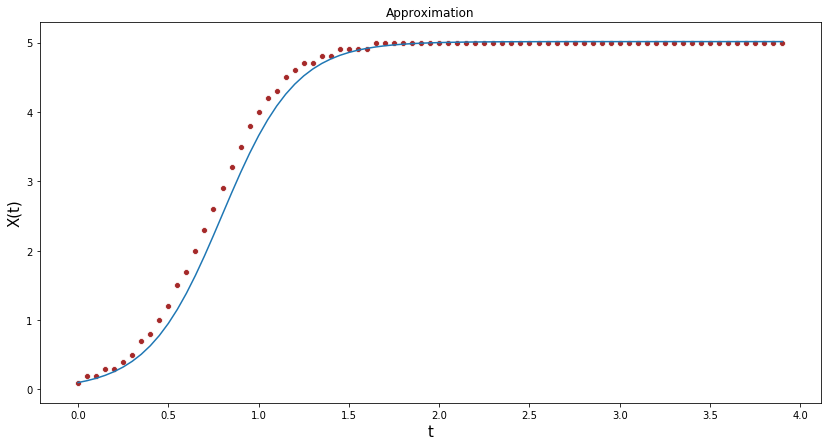

In [941]:
ver = Verhulst_Approximator(verhulst_params, verhulst_initial_condition)
ver.run()
#ver.data

## Oscilation

In [948]:
import seaborn as sns
def oscilation(z, t, delta, omega_0, omega, f):
    dx_dt = z[1]
    dy_dt = 2 * delta * z[1] - omega_0 ** 2 * z[0] - f * np.cos(omega * t)  
    return dx_dt, dy_dt

oscilate_params = {
    'delta': -0.01, 
    'omega': 0.5,
    'omega_0': 0.,
    'f': 0.
}

oscilate_initial_condition=(1., 0.1)

class Oscilate_Approximator:
    def __init__(self, 
                 oscilate_params,
                 oscilate_initial_condition,
                 noise=1,
                 step=.9,
                 step_diff=100,
                 t_begin=0,
                 t_end=50
                ):
        self.oscilate_params = oscilate_params
        self.oscilate_initial_condition = oscilate_initial_condition
        self.noise = noise
        self.step = step
        self.step_diff = step_diff
        self.t = np.arange(t_begin, t_end + 3, self.step / self.step_diff)
        self.data = self.extract_oscilation_features()
    
    def extract_oscilation_features(self):
        model = Model(oscilation, 'Oscilation')
        model.build(self.oscilate_params, self.oscilate_initial_condition, self.t)
        out = model.solved[:,0]
        theta = np.array([(2 - 2 * self.oscilate_params['delta'] - (self.oscilate_params['omega']**2) * self.step**2) / 
                          (1 - 2 * self.oscilate_params['delta'] * self.step),
                         1 / (2 * self.oscilate_params['delta'] * self.step - 1)])
        data = {
            't': self.t[0::self.step_diff][:-2],
            'x(t)': out[0::self.step_diff][:-2],
            'x(t+{})'.format(self.step):  out[0::self.step_diff][1:-1],
            'x(t+{})'.format(self.step*2):  np.round(out[0::self.step_diff][2:], self.noise) # np.round(np.array([out[0::step*100][:-1], out[0::step*100][1:]]).T @ theta, noise)
        }
        return pd.DataFrame(data=data)

    def run(self):
        solver = Approximator(self.data.to_numpy()[:,1:])
        tetas = solver.get_tetas(2)
        def findparams(theta2, theta1):
            delta =  (1 / theta2 + 1) * 1 / (2 * self.step)
            omega = np.sqrt((-theta1 * (1 - 2 * delta * self.step) + 2 - 2 * delta) / self.step**2) 
           
            return {'delta': delta, 'omega': omega, 'omega_0': 0., 'f': 0.}
        
        pred_params = findparams(tetas[0], tetas[1])
        print('Tetas : {}'.format(tetas))
        print('Predicted parameters: {}'.format(''.join(re.findall("[^}'{']", str(re.sub(': ', '=', str(pred_params)))))))
        print('Akaike : {}'.format(solver.get_Akaike()))
        print('Mallows : {}'.format(solver.get_Mallows()))
        print('RSS : {}'.format(solver.get_variance()))
        model = Model(oscilation, 'Oscilation')
        model.build(pred_params, self.oscilate_initial_condition, self.data['t'])
        model.plot(plot_y=False)
        #plt.figure(1)
        sns.scatterplot(self.data['t'], self.data['x(t+{})'.format(self.step*2)], color='brown')
        plt.title('Approximation')
        plt.xlabel('t', fontsize=15)
        plt.ylabel('X(t)', fontsize=15)


Tetas : [-0.94747458  1.75617705]
Predicted parameters: delta=-0.030798492859945355, omega=0.5068204551769868, omega_0=0.0, f=0.0
Akaike : 10.93205030877297
Mallows : 0.18848362601332624
RSS : 10.555083056746316


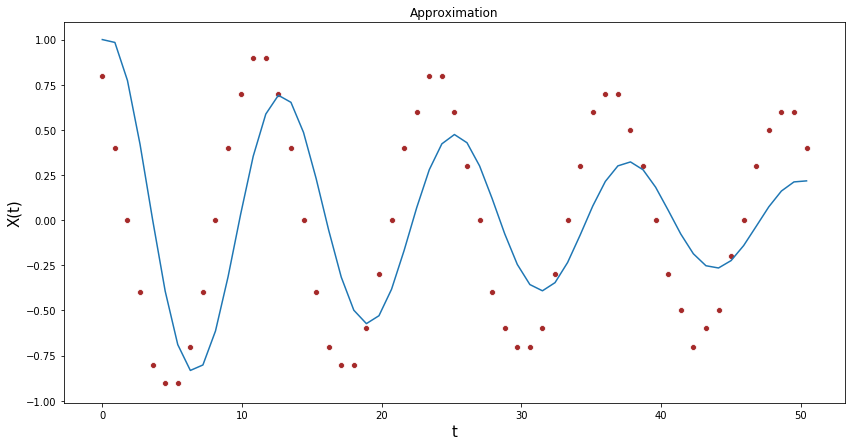

In [949]:
osc = Oscilate_Approximator(oscilate_params, oscilate_initial_condition)
osc.run()
#osc.data

## Generator

In [986]:

class Generator:
    def __init__(self, n, noise=0.01, theta=np.array([3, -2, 1, 0, 0 ])):
        self.X = np.random.uniform(0, 10, (n, theta.shape[0]))
        self.theta = theta
        self.noise = np.random.normal(0, noise, n)
        self.y = self.X @ self.theta + self.noise
    
    def run(self):
        print('n = {}'.format(self.noise.shape[0]))
        print('noise = {}'.format(0.01))
        print('X:{}'.format(self.X))
        print('y:{}'.format(self.y))
        solver = Approximator(np.vstack((self.X.T, self.y.T)).T)
        tetas = solver.get_tetas(self.X.shape[1], False)
        print(solver.RSSs)
        plt.plot(solver.RSSs)
        plt.plot(solver.Akaikes)
        plt.plot(solver.Mallowss)
        plt.legend(['RSS', 'Kakaike', 'Mallowss'])
        plt.title('Task Generator')
        print('True values: θ = {}'.format(self.theta))
        print('Estimates: θ* = {}'.format(tetas))
        #plt.plot(df['s'], df['RSS'], label='RSS')
        #plt.plot(df['s'], df['Cp'], label='Cp')
        #plt.plot(df['s'], df['FPE'], label='FPE')
        #plt.legend()
        #plt.show()
        #print(df)

n = 10
noise = 0.01
X:[[6.32252321 1.41131513 4.06095311 3.4614022  4.24212257]
 [5.31260097 3.25919133 9.32688831 8.7483332  9.24563731]
 [3.98104081 3.02767606 2.69876176 2.18761378 5.09284127]
 [9.67880361 7.04806691 4.06736812 7.64318906 4.68395578]
 [5.5682866  1.31079006 8.4148211  9.11883914 3.86755116]
 [5.87976285 2.16914385 5.74730426 4.29238947 5.80387427]
 [8.68388639 2.75915718 9.61896795 1.94778842 6.91694251]
 [0.11874965 1.21664512 7.08239377 0.19985122 6.15375486]
 [9.42072077 3.68829647 1.28918053 6.84687326 0.72653096]
 [1.22103279 3.02359529 7.88979174 4.20999944 3.60153514]]
y:[20.2058925  18.74630856  8.58653209 19.00764513 22.49810077 19.04830511
 30.15231275  5.00535247 22.17474989  5.50569952]
[225.01763635630093, 188.16387203799644, 1.9895196601282805e-13, 1.9895196601281248e-13, 1.9895196601277459e-13]
True values: θ = [ 3 -2  1  0  0]
Estimates: θ* = [ 3.00000000e+00 -2.00000000e+00  1.00000000e+00  1.68753900e-14
  3.90798505e-14]


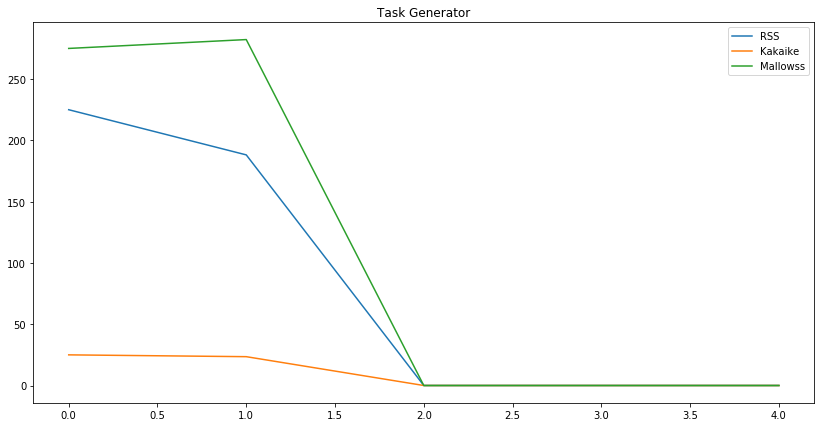

In [987]:
Generator(10, noise=0).run()

In [884]:
def extract_verhulst_features(verhulst_params, verhulst_initial_condition, noise=3, step=1e0, t_begin=0, t_end=100):
    t = np.arange(t_begin, t_end + 2, step / 100)
    model = Model(Verhulst, 'Verhulst')
    model.build(verhulst_params, verhulst_initial_condition, t)
    out = model.solved[:,0]
    theta = np.array([verhulst_params['r'] * verhulst_params['k'] + 1 / step, - verhulst_params['r']])
    data = {
        't': t[0::100][:-1],
        'N(t)': out[0::100][:-1],
        'N^2(t)': np.square(out[0::100][:-1]),
        'N(t+{})'.format(step): out[0::100][1:] # np.round(np.array([out[0::100][:-1], np.square(out[0::100][:-1])]).T @ theta, noise)
    }
    return pd.DataFrame(data=data)

def extract_oscilation_features(oscilate_params, oscilate_initial_condition, noise=3, step=1, t_begin=0, t_end=100):
    t = np.arange(t_begin, t_end + 3, step/100)
    model = Model(oscilation, 'Oscilation')
    model.build(oscilate_params, oscilate_initial_condition, t)
    out = model.solved[:,0]
    theta = np.array([(2 - 2 * oscilate_params['delta'] - (oscilate_params['omega']**2) * step**2) / (1 - 2 * oscilate_params['delta'] * step),
                     1 / (2 * oscilate_params['delta'] * step - 1)])
    data = {
        't': t[0::step*100][:-2],
        'x(t)': out[0::step*100][:-2],
        'x(t+{})'.format(step):  out[0::step*100][1:-1], # out[0::step*100][2:] # 
        'x(t+{})'.format(step*2):  np.round(np.array([out[0::step*100][:-2], out[0::step*100][2:]]).T @ theta, noise)
    }
    return pd.DataFrame(data=data)

In [885]:
extract_oscilation_features(oscilate_params, oscilate_initial_condition)

,t,x(t),x(t+1),x(t+2)
0,0.0,1.000000,0.869033,1.346
1,1.0,0.869033,0.473526,1.856
2,2.0,0.473526,-0.137890,1.977
3,3.0,-0.137890,-0.847302,1.588
4,4.0,-0.847302,-1.484128,0.683
...,...,...,...,...
96,96.0,-14981.972634,-13768.027184,-18335.530
97,97.0,-13768.027184,-8553.633397,-26842.569
98,98.0,-8553.633397,133.612870,-29957.696
99,99.0,133.612870,10708.025063,-25642.806


In [886]:
extract_verhulst_features(verhulst_params, verhulst_initial_condition)
#extract_oscilation_features(oscilate_params, oscilate_initial_condition)
solver = Approximator(extract_verhulst_features(verhulst_params, verhulst_initial_condition).to_numpy())
tetas = solver.get_tetas(4)
variance = solver.get_variance()
mallows = solver.get_Mallows()
akaike = solver.get_Akaike()
print('tetas are {}'.format(tetas))
print("Variance is " + str(variance))
print("Mallows is " + str(mallows))
print("Akaike is " + str(akaike))

tetas are [-1.73194792e-14 -1.27329258e-11  1.95541361e-11  1.00000000e+00]
Variance is 12.321463708961705
Mallows is 0.3771876645600525
Akaike is 13.07583903808181


In [887]:
solver = Approximator(extract_oscilation_features(oscilate_params, oscilate_initial_condition).to_numpy())
tetas = solver.get_tetas(3)
variance = solver.get_variance()
mallows = solver.get_Mallows()
akaike = solver.get_Akaike()
print('tetas are {}'.format(tetas))
print("Variance is " + str(variance))
print("Mallows is " + str(mallows))
print("Akaike is " + str(akaike))

tetas are [-1.86918915e-07  3.46425342e+00 -2.43795421e+00]
Variance is 2627057179.754114
Mallows is 53071862.21725464
Akaike is 2733200904.188624


In [888]:
settings = (0, 10, 1)
step = 100

oscilate = Model(oscilation, 'Oscilation')
oscilate_params = {
    'delta': 0.1, 
    'omega': 0.5,
    'omega_0': 0.,
    'f': 0.
}
oscilate_initial_condition = (1., 0.)
oscilate_time_points = np.linspace(0, 400, 40000)
oscilate.build(oscilate_params, oscilate_initial_condition, oscilate_time_points)

y = oscilate.get_values(step)
h = (oscilate_time_points[-1] - oscilate_time_points[0])*step/len(oscilate_time_points)

orders = [3, 2, 1]
teta_1 = (oscilate_params['omega'] ** 2 - 2 + 2 * oscilate_params['delta']) / (2 * oscilate_params['delta'] - 1)
funcs = [lambda x: x, lambda x: x, lambda x: x]
data = form_discrete_values(funcs, y, orders)
params = oscilate.get_values(step)
delta = (1. / (2*h) ) * ((params[0]) + 1)
omega = ((params[1] * (2 * h * oscilate_params['delta'] - 1) + 
          (2 - 2 * h * oscilate_params['delta'])) ** 0.5) * (1. / h)

#print(delta)
#print(np.sqrt(params[0] * (2 * delta - 1) + 2 - 2 * delta))

# Example of how the code works with dummy data

In [889]:
X = np.array([[np.random.uniform(0, 1) for j in range(10)] for i in range(100)])
y = np.array([[np.random.uniform(0, 1)] for i in range(100)])
np.linalg.lstsq(X, y, rcond=1)[0]

oscilate = Model(oscilation, 'Oscilation')
solver = Approximator(data)
tetas = solver.get_tetas(2)
variance = solver.get_variance()
mallows = solver.get_Mallows()
akaike = solver.get_Akaike()
print(tetas)
print("variance is " + str(variance))
print("Mallows is " + str(mallows))
print("Akaike is " + str(akaike))

[-2.38218152  2.58247778]
variance is 1.3657160302803389e+35
Mallows is 3.448777854243224e+32
Akaike is 1.3726135859888254e+35


## Example

In [890]:
def create_df(RSS_next,numOfColX,yShape):
    df = pd.DataFrame(columns=['s', 'RSS', 'Cp', 'FPE'])
    Cp = RSS_next + 2 * numOfColX
    numOfRowY = yShape
    FPE = (numOfRowY + numOfColX) / (numOfRowY - numOfColX) * RSS_next
    df = df.append({'s': numOfColX, 'RSS': RSS_next, 'Cp': Cp, 'FPE': FPE},  ignore_index=True)
    return df

def RMNK(X, y, s=None, printt=False, cr_df=False):
    numOfColX = X.shape[1]
    if numOfColX > 1:
        if cr_df:
            w, H_inv, RSS, df = RMNK(X[:,:-1], y, s, printt, cr_df)
            if s is not None and numOfColX > s:
                return w, H_inv, RSS, df
        else:
            w, H_inv, RSS = RMNK(X[:,:-1], y, s, printt, cr_df)
            if s is not None and numOfColX > s:
                return w, H_inv, RSS
        
        h = (X[:,:-1].T @ X[:,-1]).reshape(-1,1) 
        η  = X[:,-1].T @ X[:,-1] 
        α = H_inv @ h 
        β  = η  - h.T @ α 
        β_inv = 1 /β  
        γ = X[:,-1].T @ y 
        ν =β_inv * (γ - h.T @ w) 
        w = np.vstack((w - ν * α, ν))  
        H_next_inv = np.vstack((np.hstack((H_inv + β_inv * α @ α.T, (- β_inv * α).reshape(-1, 1))),
                               np.hstack((-β_inv * α.T, β_inv))))
        RSS_next = (RSS - ν.flatten() ** 2 * β.flatten())[0]

    else: 
        H_inv = np.array([[0]])
        η  = β = X[:,-1].T @ X[:,-1]
        β_inv = 1 / β
        α = h = np.array([0])
        γ = X[:,-1].T @ y
        ν = np.array([β_inv * γ])
        w = np.array([ν])
        H_next_inv = np.array(β_inv).reshape(1, 1)
        RSS_next = (y.T @ y - y.T @ X[:,-1].reshape(-1, 1) @ w)[0]
        if cr_df:
            df = pd.DataFrame(columns=['s', 'RSS', 'Cp', 'FPE'])
        
    if printt:
        print('Step №{}'.format(numOfColX))
        '''print('h_{}:{}'.format(numOfColX, h.reshape(-1,1)[:,0]))
            print('η _{}:{}'.format(numOfColX, η ))
            print('α_{}:{}'.format(numOfColX, α.reshape(-1,1)[:,0]))
            print('β_{}:{}'.format(numOfColX, β))
            print('γ_{}:{}'.format(numOfColX, γ))
            print('ν_{}:{}'.format(numOfColX, ν))'''
        print('---θ{}: {}'.format(numOfColX, w[:, 0]))
        print('---H{}_inv:\n{}'.format(numOfColX, H_next_inv))
        print('---RSS{}: {}'.format(numOfColX, RSS_next))
    
    if cr_df:
        Cp = RSS_next + 2 * numOfColX
        numOfRowY = y.shape[0]
        FPE = (numOfRowY + numOfColX) / (numOfRowY - numOfColX) * RSS_next
        df = df.append({'s': numOfColX, 'RSS': RSS_next, 'Cp': Cp, 'FPE': FPE},  ignore_index=True)
        return w, H_next_inv, RSS_next, df
    return w, H_next_inv, RSS_next


Fergulst Model:
μ = 0.0001
k = 10
N0 = 100
Noise: C = 4
n = 100
t =[0;1000] with h=10



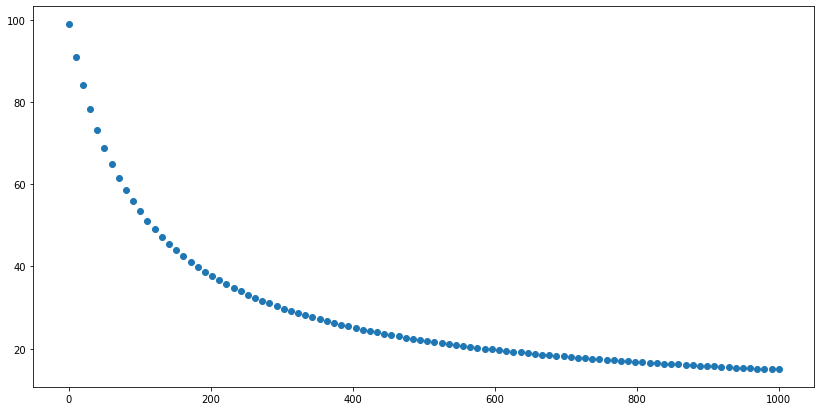

      i     t        N(t)        N^2(t)   N(t+1)
0     1     0  100.000000  10000.000000  99.1000
1     2    10   91.705134   8409.831579  90.9559
2     3    20   84.746199   7181.918243  84.1128
3     4    30   78.824789   6213.347354  78.2823
4     5    40   73.725211   5435.406776  73.2554
..  ...   ...         ...           ...      ...
95   96   959   15.261184    232.903728  15.2532
96   97   969   15.180913    230.460134  15.1730
97   98   979   15.102277    228.078781  15.0946
98   99   989   15.025230    225.757532  15.0177
99  100  1000   14.949727    223.494342  14.9423

[100 rows x 5 columns]
RMNKO:
Step №1
---θ1: [0.99550587]
---H1_inv:
[[8.46186225e-06]]
---RSS1: 0.8488937634974718
Step №2
---θ2: [ 1.00099975e+00 -9.99949621e-05]
---H2_inv:
[[ 4.40171822e-05 -6.47148226e-07]
 [-6.47148226e-07  1.17788513e-08]]
---RSS2: 8.286802521961789e-08
(array([[ 1.00099975e+00],
       [-9.99949621e-05]]), array([[ 4.40171822e-05, -6.47148226e-07],
       [-6.47148226e-07,  1.1778851

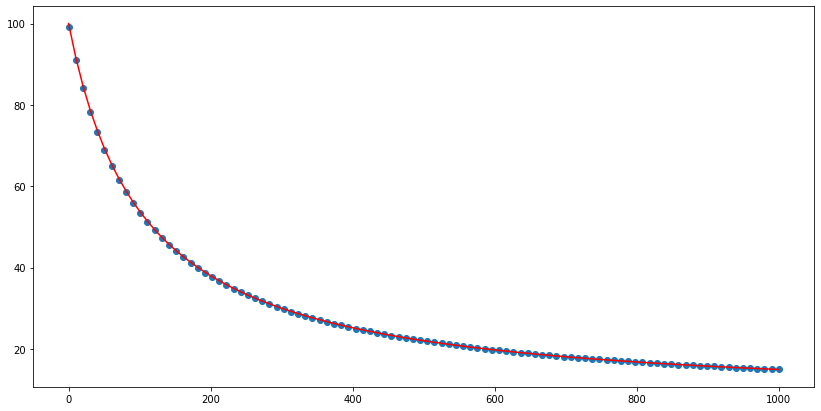

,C,n,θ_1*,θ_2*,μ*,k*
0,2.0,20.0,1.001003,-0.000100,0.000100,10.037421
1,2.0,50.0,1.001025,-0.000101,0.000101,10.196492
2,2.0,70.0,1.001015,-0.000100,0.000100,10.132916
3,5.0,20.0,1.001000,-0.000100,0.000100,10.000571
4,5.0,50.0,1.001000,-0.000100,0.000100,10.000262
5,5.0,70.0,1.001000,-0.000100,0.000100,10.000038
6,10.0,20.0,1.001000,-0.000100,0.000100,10.000000
7,10.0,50.0,1.001000,-0.000100,0.000100,10.000000
8,10.0,70.0,1.001000,-0.000100,0.000100,10.000000


In [891]:
def Fergulst(N, t, μ, k):
    return μ * N * (k - N)

def findtheta(μ,k):
    theta1 = μ * k + 1
    theta2 = -μ
    return np.array([theta1, theta2])

def findparams(theta1, theta2):
    μ = - theta2
    k = (1 - theta1) / theta2
    return μ, k

k = 10
μ = 0.0001
N0 = 100
t_start = 0
t_end = 1000
n = 100
n_list = [20, 50, 70]
C = 4
C_list = [2, 5, 10]

theta = findtheta(μ,k)
h = int((t_end - t_start) / (n - 1))
t = np.linspace(t_start, t_end, num=n)
N = odeint(Fergulst, N0, t, (μ, k))

df = pd.DataFrame()
df['i'] = range(1, n+1)
df['t'] = list(map(int, t))
df['N(t)'] = N.flatten()
df['N^2(t)'] = np.square(N.flatten())
df['N(t+1)'] = np.array(df[['N(t)','N^2(t)']]) @ theta
df['N(t+1)'] = np.round(df['N(t+1)'], C)
X = np.array(df[['N(t)', 'N^2(t)']])
y = np.array(df['N(t+1)'])
print('Fergulst Model:\nμ = {}\nk = {}\nN0 = {}'.format(μ, k, N0))
print('Noise: C = {}'.format(C))
print('n = {}'.format(n))
print('t =[{};{}] with h={}\n'.format(t_start,t_end,h))
plt.scatter(t, y)
plt.show()
print(df)
print('RMNKO:')
theta_est = RMNK(X, y, printt=True)
print(theta_est)
theta_est = theta_est[0][:,0]
print(theta_est)
μ_est, k_est = findparams(*theta_est)
print('True values/estimates:θ_1 = {} θ_2 = {} θ_1* = {} θ_2* = {}'.format(*theta,*theta_est))
print('True values/estimates: μ = {} k = {} μ* = {} k* = {}'.format(μ, k, μ_est, k_est))
plt.scatter(t, y)
t_plot = np.linspace(t_start, t_end, num=n)
plt.plot(t_plot, odeint(Fergulst, N0, t_plot, (μ_est, k_est)), 'r')
plt.show()
param_df = pd.DataFrame(columns=['C', 'n', 'θ_1*', 'θ_2*', 'μ*', 'k*'])
for C in C_list:
    for n in n_list: 
        h = int((t_end - t_start) / (n - 1))
        t = np.linspace(t_start, t_end, num=n)
        N = odeint(Fergulst, N0, t, (μ, k))
        df = pd.DataFrame()
        df['i'] = range(1, n+1)
        df['t'] = list(map(int, t))
        df['N(t)'] = N.flatten()
        df['N^2(t)'] = np.square(N.flatten())
        df['N(t+1)'] = np.array(df[['N(t)','N^2(t)']]) @ theta
        df['N(t+1)'] = np.round(df['N(t+1)'], C)
        X = np.array(df[['N(t)', 'N^2(t)']])
        y = np.array(df['N(t+1)'])
        theta_est = RMNK(X, y, printt=False)[0][:,0]
        μ_est, k_est = findparams(*theta_est)
        param_df = param_df.append({'C': C, 'n': n,'θ_1*': theta_est[0], 'θ_2*': theta_est[1],'μ*': μ_est, 'k*': k_est}, ignore_index=True)
param_df

δ = 0.005 ω0^2 = 0.01 x0 = 5 x00 = 2
C = 2
n = 100
t =[0;1000] with h=10



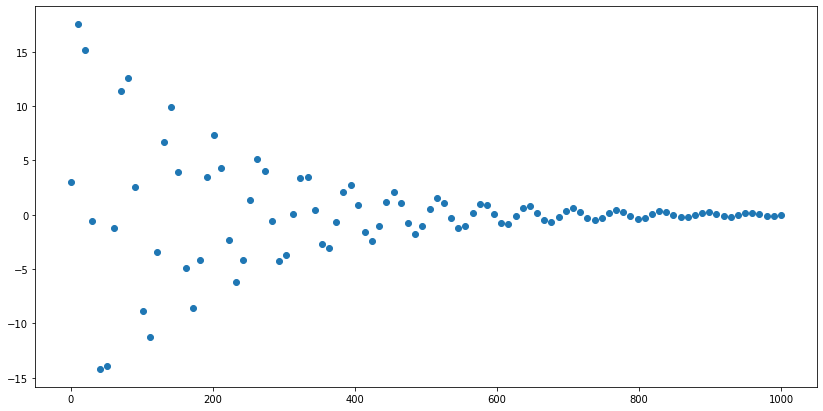

      i     t       x(t)     x(t+1)  x(t+2)
0     1     0   5.000000   7.000000    2.97
1     2    10  18.845271  19.939029   17.58
2     3    20  14.574472  13.874824   15.12
3     4    30  -2.267788  -3.965348   -0.56
4     5    40 -15.471944 -16.559489  -14.24
..  ...   ...        ...        ...     ...
95   96   959   0.166296   0.166775    0.16
96   97   969   0.048257   0.035219    0.06
97   98   979  -0.101425  -0.115068   -0.09
98   99   989  -0.146385  -0.148422   -0.14
99  100  1000  -0.056637  -0.046370   -0.07

[100 rows x 5 columns]
RMNKO
Step №1
---θ1: [0.95814633]
---H1_inv:
[[0.00045498]]
---RSS1: 19.32925232365642
Step №2
---θ2: [ 1.98091079 -0.9906825 ]
---H2_inv:
[[ 0.05457455 -0.05242195]
 [-0.05242195  0.05077759]]
---RSS2: 0.0008069832257255882
true values/estimates:θ_1 = 1.98019801980198 θ_2 = -0.9900990099009901 θ_1* = 1.9809107895197042 θ_2* = -0.9906825049560994
true values/estimates: δ = 0.005 ω0^2 = 0.01 δ* = 0.0047025636353159594 ω0^2* = 0.00986361966372695

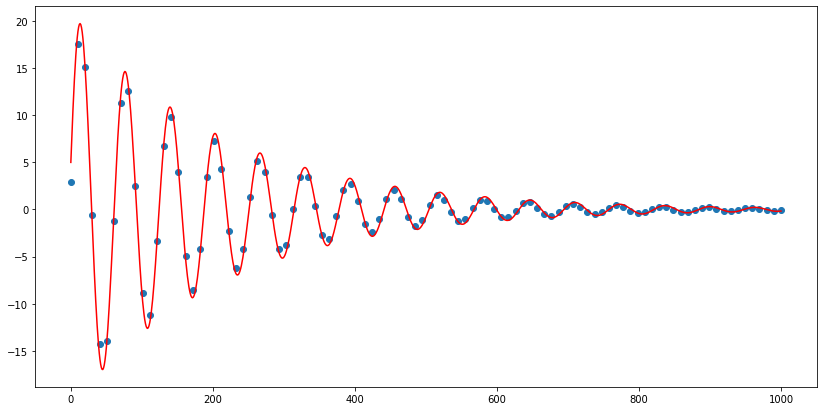

,C,n,θ_1*,θ_2*,δ*,ω0_sqr*
0,2.0,20.0,1.978366,-0.988289,0.005925,0.010041
1,2.0,50.0,1.980542,-0.990451,0.004821,0.010005
2,2.0,150.0,1.979551,-0.989452,0.005330,0.010007
3,5.0,20.0,1.980197,-0.990098,0.005001,0.010000
4,5.0,50.0,1.980198,-0.990099,0.005000,0.010000
5,5.0,150.0,1.980197,-0.990098,0.005000,0.010000
6,10.0,20.0,1.980198,-0.990099,0.005000,0.010000
7,10.0,50.0,1.980198,-0.990099,0.005000,0.010000
8,10.0,150.0,1.980198,-0.990099,0.005000,0.010000


In [892]:
def ZgasColiv(x, t, δ, ω0_sqr):
    return [x[1],  - 2 * δ * x[1] - ω0_sqr * x[0]]        
def findtheta(δ,ω0_sqr):
    d = 1 + 2 * δ
    theta1 = (2 + 2 * δ - ω0_sqr) / d
    theta2 = - 1 / d
    return np.array([theta1, theta2])
def findparams(theta1, theta2):
    δ = - (1 / theta2 + 1) / 2
    ω0_sqr = 1 - 1 / theta2 + theta1 / theta2
    return δ, ω0_sqr
 
δ = 0.005
ω0_sqr = 0.01
x0 = 5
x00 = 2
t_start = 0
t_end = 1000
n = 100
n_list = [20, 50, 150]
C = 2
C_list = [2, 5, 10]

theta = findtheta(δ,ω0_sqr)
h = int((t_end - t_start) / (n - 1))
t = np.linspace(t_start, t_end, num=n)
x = odeint(ZgasColiv, np.array([x0, x00]), t, (δ, ω0_sqr))
x1 = x0 + x00
x11 = x00
x_1 = odeint(ZgasColiv, np.array([x1, x11]), t+1, (δ, ω0_sqr))
df = pd.DataFrame()
df['i'] = range(1, n+1)
df['t'] = list(map(int, t))
df['x(t)'] = x[:,0].flatten()
df['x(t+1)'] = x_1[:,0].flatten()
df['x(t+2)'] = np.array(df[['x(t)','x(t+1)']]) @ theta
df['x(t+2)'] = np.round(df['x(t+2)'], C)
X = np.array(df[['x(t)', 'x(t+1)']])
y = np.array(df['x(t+2)'])  
    
print('δ = {} ω0^2 = {} x0 = {} x00 = {}'.format(δ, ω0_sqr, x0, x00))
print('C = {}'.format(C))
print('n = {}'.format(n))
print('t =[{};{}] with h={}\n'.format(t_start,t_end,h))
plt.scatter(t, y)
plt.show()
print(df)

print('RMNKO')
theta_pred = RMNK(X, y, printt=True)[0][:,0]
δ_pred, ω0_sqr_pred = findparams(*theta_pred)
print('true values/estimates:θ_1 = {} θ_2 = {} θ_1* = {} θ_2* = {}'.format(*theta,*theta_pred))
print('true values/estimates: δ = {} ω0^2 = {} δ* = {} ω0^2* = {}'.format(δ, ω0_sqr,δ_pred, ω0_sqr_pred))
plt.scatter(t, y)
t_plot = np.linspace(t_start, t_end, num=n * 10)
plt.plot(t_plot, odeint(ZgasColiv, np.array([x0, x00]),t_plot, (δ_pred, ω0_sqr_pred))[:,0], 'r')
plt.show()

param_df = pd.DataFrame(columns=['C', 'n', 'θ_1*', 'θ_2*','δ*', 'ω0_sqr*'])
for C in C_list:
    for n in n_list: 
        h = int((t_end - t_start) / (n - 1))
        t = np.linspace(t_start, t_end, num=n)
        x = odeint(ZgasColiv, np.array([x0, x00]), t, (δ, ω0_sqr))
        x1 = x0 + x00
        x11 = x00
        x_1 = odeint(ZgasColiv, np.array([x1, x11]), t+1, (δ, ω0_sqr))
        df = pd.DataFrame()
        df['i'] = range(1, n+1)
        df['t'] = list(map(int, t))
        df['x(t)'] = x[:,0].flatten()
        df['x(t+1)'] = x_1[:,0].flatten()
        df['x(t+2)'] = np.array(df[['x(t)','x(t+1)']]) @ theta
        df['x(t+2)'] = np.round(df['x(t+2)'], C)
        X = np.array(df[['x(t)', 'x(t+1)']])
        y = np.array(df['x(t+2)'])  
        theta_pred = RMNK(X, y, printt=False)[0][:,0]
        δ_pred, ω0_sqr_pred = findparams(*theta_pred)
        param_df =param_df.append({'C': C, 'n': n,'θ_1*': theta_pred[0], 'θ_2*': theta_pred[1],'δ*': δ_pred, 'ω0_sqr*': ω0_sqr_pred},ignore_index=True)       
param_df



## Generator 2

n = 10
σ = 0.1
X:[[8.77083464 6.73627788 5.95617818 5.59012167 6.41864543]
 [0.64449354 9.99711826 0.82251342 5.83006107 7.93943715]
 [0.0647317  0.92530046 2.65867563 8.34915688 1.18679949]
 [6.49881127 5.71128955 3.16024996 1.87071019 9.7284014 ]
 [2.97227155 0.45906522 6.14533452 9.16646385 5.04774045]
 [8.99915196 0.2635685  1.93090265 5.39285219 1.34706797]
 [1.31848504 6.158564   5.86185401 4.80577564 2.2067755 ]
 [5.34125796 0.91515865 6.4027454  4.06956985 3.83504642]
 [4.96339915 2.98371031 2.15084352 1.35450431 8.48788807]
 [0.36212258 2.40071221 2.02554521 2.68974122 8.34422652]]
y:[ 18.77589785 -17.22839208   1.00245     11.23719364  14.13664235
  28.39060318  -2.49939899  20.59501889  11.07658765  -1.69281027]
Step №1
---θ1: [2.59138355]
---H1_inv:
[[0.00378165]]
---RSS1: 562.7104806589662
Step №2
---θ2: [ 3.48045978 -1.73988356]
---H2_inv:
[[ 0.00537912 -0.00312618]
 [-0.00312618  0.00611779]]
---RSS2: 67.89242986341412
Step №3
---θ3: [ 2.99896691 -1.99917128  0.99938757]

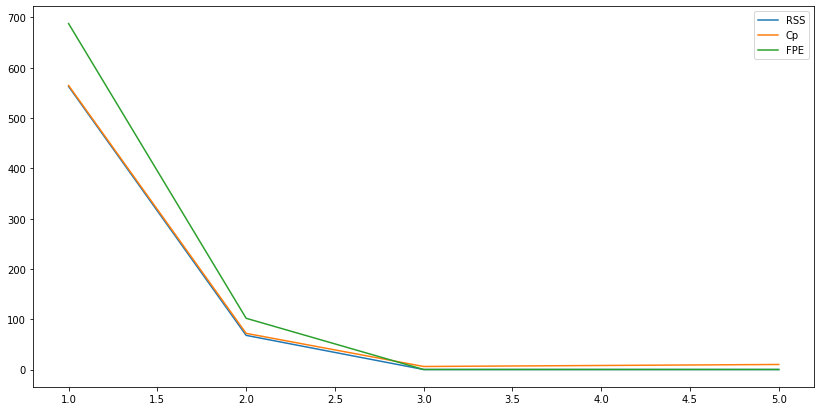

     s         RSS          Cp         FPE
0  1.0  562.710481  564.710481  687.757254
1  2.0   67.892430   71.892430  101.838645
2  3.0    0.000348    6.000348    0.000647
3  4.0    0.000346    8.000346    0.000807
4  5.0    0.000308   10.000308    0.000925

n = 10
σ = 0.5
X:[[5.73356586 5.25689871 8.75773562 4.28062657 1.98153822]
 [8.66199226 9.39978591 8.04393023 3.3988605  7.80967086]
 [7.16839401 5.20600054 3.88182661 8.04524807 2.0948216 ]
 [7.97629466 3.83768583 0.4255075  7.64981491 5.61895302]
 [5.15738656 0.73467356 5.42044814 1.43503807 8.29702704]
 [1.91254394 8.60666857 2.80511661 0.60263322 3.26049598]
 [8.9803442  9.22017972 3.85591564 3.76177749 3.88261407]
 [6.85864886 2.37216591 4.12009957 4.98630466 1.97555737]
 [4.47587133 8.57068176 7.04639601 9.7868632  7.37164312]
 [8.61747317 5.68379908 4.65561848 4.41664942 5.40105538]]
y:[15.45610858 15.236312   14.98291487 16.69409548 19.40700858 -8.67239198
 12.3536686  19.94392978  3.34326693 19.13102249]
Step №1
---θ1: [2.

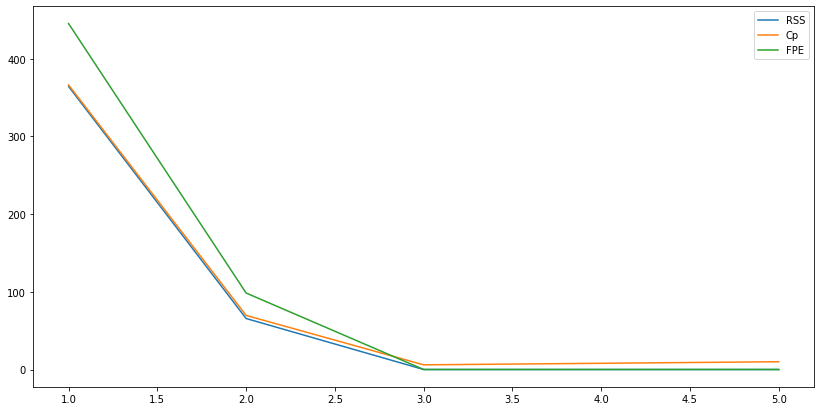

     s         RSS          Cp         FPE
0  1.0  364.342426  366.342426  445.307410
1  2.0   65.625122   69.625122   98.437682
2  3.0    0.000875    6.000875    0.001625
3  4.0    0.000555    8.000555    0.001295
4  5.0    0.000501   10.000501    0.001503

n = 10
σ = 1
X:[[3.04584933 3.22790695 9.6126392  4.80218777 9.99989248]
 [8.27274503 0.34449498 3.62792675 4.54790316 9.60381514]
 [2.63633961 7.91165928 0.66794371 0.30102377 3.92929451]
 [3.57338336 6.82426099 3.8919933  2.47921895 5.71037527]
 [6.15907331 9.48234322 4.36096438 5.99282007 7.7803401 ]
 [2.30915157 3.48102094 4.94940526 4.64721811 9.96710794]
 [2.27113471 7.6369736  3.04351574 5.2753664  3.28419028]
 [0.35229324 3.21196427 5.05151288 1.69795461 3.10685384]
 [7.75096896 5.44043641 2.78630248 0.49984435 2.3538171 ]
 [1.68984273 4.96519769 5.68149368 5.65675021 2.80146946]]
y:[12.30140747 27.77353315 -7.23463722  0.95880722  3.87799468  4.90491738
 -5.40182046 -0.30463713 15.14221842  0.83484296]
Step №1
---θ1: [1.88

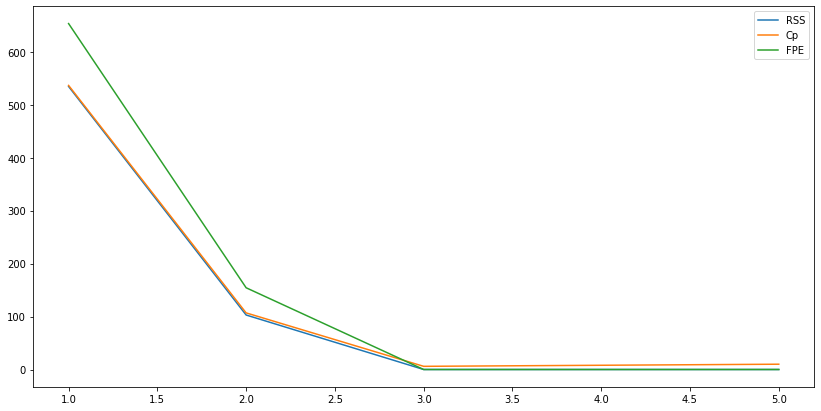

     s         RSS          Cp         FPE
0  1.0  534.275710  536.275710  653.003646
1  2.0  102.868520  106.868520  154.302781
2  3.0    0.001167    6.001167    0.002168
3  4.0    0.000938    8.000938    0.002188
4  5.0    0.000929   10.000929    0.002788

n = 30
σ = 0.1
X:[[4.16969206 8.16737303 3.29881926 0.30937202 1.76682857]
 [5.30679446 8.04577976 2.02330063 9.68025458 5.08435867]
 [0.1964022  9.29971218 4.00729077 1.12389608 2.70463226]
 [4.27925093 7.40229454 4.99961533 9.68069106 1.90005658]
 [9.56191398 9.2504681  6.53870813 8.97850459 1.28628388]
 [8.95615106 4.80407204 1.75550187 7.50591898 4.47844245]
 [0.7281855  1.67392155 4.34557608 0.79004926 4.67978975]
 [7.28153067 7.42862885 4.20268584 6.53513193 9.11650238]
 [5.32545684 9.34220206 7.5273184  7.99522382 4.77619212]
 [2.84277321 1.35483106 4.31440282 5.857735   2.71812275]
 [8.75211845 8.4934099  5.50113865 6.06940725 4.80001838]
 [1.53407685 6.06185735 4.55747374 5.72315632 8.85006557]
 [1.49439086 1.69147562 1.94

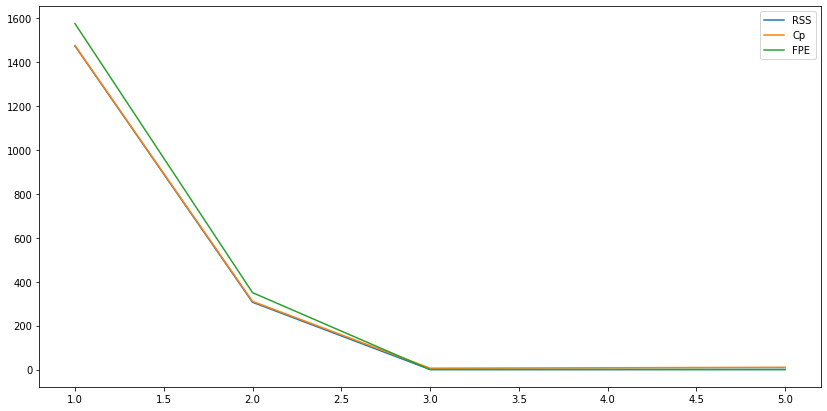

     s          RSS           Cp          FPE
0  1.0  1472.551384  1474.551384  1574.106651
1  2.0   306.031404   310.031404   349.750176
2  3.0     0.001577     6.001577     0.001928
3  4.0     0.001568     8.001568     0.002050
4  5.0     0.001563    10.001563     0.002189

n = 30
σ = 0.5
X:[[2.09659679 7.41226824 3.87193487 6.14665952 9.25391201]
 [9.48408264 4.579573   2.39974524 0.52996132 4.86442297]
 [1.57332582 4.47875012 7.84396169 7.12644197 7.09369834]
 [7.52615104 7.27885654 3.65855336 5.7954503  1.17011116]
 [1.33273056 5.95234463 2.6249806  6.10388948 6.14278699]
 [0.79476728 1.19470136 1.47144501 4.08362919 3.09850213]
 [0.44188869 7.75080683 2.83674927 5.77953487 4.67438419]
 [7.54996129 4.54313886 0.44298571 4.72394157 6.30787147]
 [4.28795378 4.55501011 9.30263629 9.43988222 2.71799028]
 [3.04266115 5.52841276 4.10403274 0.47194506 8.23270231]
 [0.28839747 1.52410641 0.43305717 0.57478066 6.87602537]
 [9.16197363 8.61684906 4.44416277 3.47659589 1.03141734]
 [7.814905

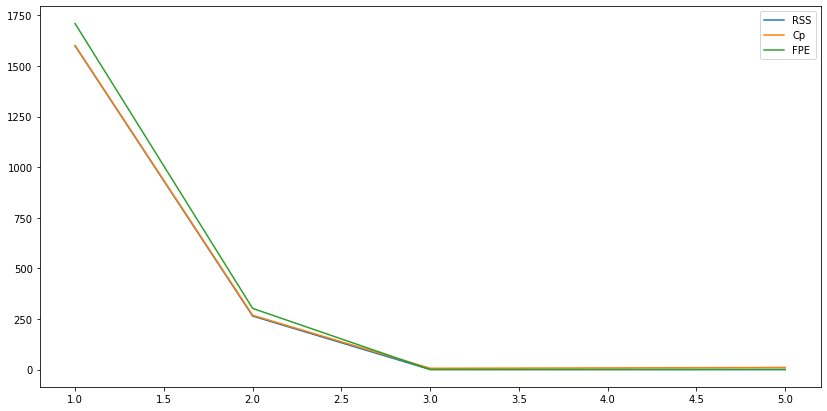

     s          RSS           Cp          FPE
0  1.0  1598.960232  1600.960232  1709.233352
1  2.0   264.192885   268.192885   301.934726
2  3.0     0.002163     6.002163     0.002644
3  4.0     0.002159     8.002159     0.002823
4  5.0     0.002119    10.002119     0.002967

n = 30
σ = 1
X:[[6.65625358e-01 7.77445771e+00 8.56160769e+00 7.15124697e+00
  5.08497878e+00]
 [1.13864867e+00 4.22073095e+00 7.91975551e-01 2.97952428e+00
  5.78398851e+00]
 [7.99070211e+00 3.19349399e+00 7.62999472e+00 8.13836655e+00
  3.27293991e+00]
 [1.76288347e+00 9.75128783e+00 6.78255331e+00 4.16716918e+00
  7.03920156e+00]
 [6.86706995e+00 8.03339851e+00 3.76679672e+00 7.91704971e-01
  7.51555962e+00]
 [1.62943616e+00 5.08828904e+00 6.48397085e+00 1.78524802e-01
  4.96860645e+00]
 [2.27540736e+00 5.04509251e+00 6.61829165e+00 6.86816843e+00
  5.75094722e+00]
 [4.47169800e+00 8.57579475e+00 5.63740023e-01 8.85440610e+00
  5.35388897e+00]
 [8.74362649e+00 9.53426169e+00 1.14684583e+00 2.22103356e+00
  7.18

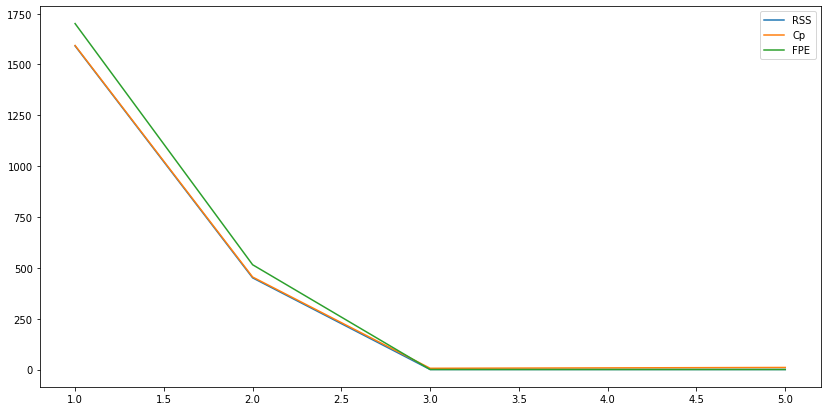

     s          RSS           Cp          FPE
0  1.0  1591.297711  1593.297711  1701.042381
1  2.0   450.707101   454.707101   515.093830
2  3.0     0.002812     6.002812     0.003436
3  4.0     0.002806     8.002806     0.003669
4  5.0     0.002806    10.002806     0.003928

n = 100
σ = 0.1
X:[[2.34658280e+00 3.41716831e+00 5.53343898e+00 6.07869142e+00
  7.61425321e+00]
 [3.16679822e+00 7.16144055e+00 1.49349253e+00 7.87469876e+00
  9.77477905e+00]
 [8.85544770e-01 8.10393143e+00 1.11175407e+00 7.31751828e+00
  6.23503501e+00]
 [6.38590875e+00 5.02725233e+00 9.31543267e+00 6.50707581e+00
  5.71359414e+00]
 [3.13183784e+00 4.56136050e+00 2.57120544e+00 9.27861247e+00
  6.31782864e+00]
 [7.69885551e+00 7.09103221e+00 4.21150883e+00 9.96223540e+00
  3.79333522e+00]
 [2.40353186e+00 3.05277987e+00 5.98616702e+00 5.69936742e+00
  7.95712402e+00]
 [7.54034795e+00 6.49089117e+00 6.22292646e+00 1.67105353e+00
  8.84620702e+00]
 [3.95278638e-02 5.36987194e+00 7.88363236e+00 8.23234011e+00
  8

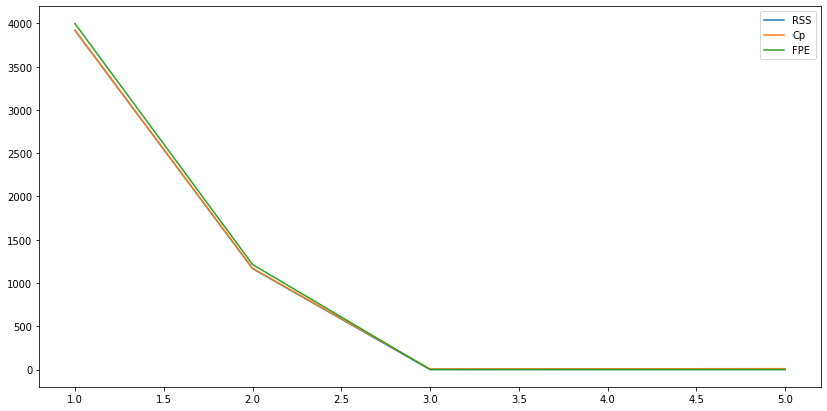

     s          RSS           Cp          FPE
0  1.0  3919.648814  3921.648814  3998.833638
1  2.0  1166.648977  1170.648977  1214.267303
2  3.0     0.010948     6.010948     0.011625
3  4.0     0.010941     8.010941     0.011853
4  5.0     0.010885    10.010885     0.012031

n = 100
σ = 0.5
X:[[1.29270051 8.16081137 8.1260199  2.46558747 9.98047903]
 [0.7221681  5.22703923 4.6004132  1.07626179 3.4353417 ]
 [9.90724143 6.85462746 5.09387718 8.61111177 7.23704306]
 [6.58774501 7.54068014 4.92740084 1.33513349 9.28744897]
 [0.76164117 8.49782653 5.87072347 7.16504828 6.83663058]
 [2.36205506 1.1047154  2.29000941 8.57040923 6.94792074]
 [5.00183505 6.07857419 6.27640124 8.51842362 9.3328665 ]
 [1.61914571 3.04712217 7.83227396 6.82513687 0.45551187]
 [9.89512261 3.71355256 8.42097013 2.63188541 5.21905899]
 [2.90515023 7.9452499  4.29534674 2.11703123 0.02505938]
 [0.19430392 5.30056448 1.5410611  2.66108006 0.99669843]
 [6.95701008 6.41234828 9.38956388 4.13494659 6.13241776]
 [9.92925

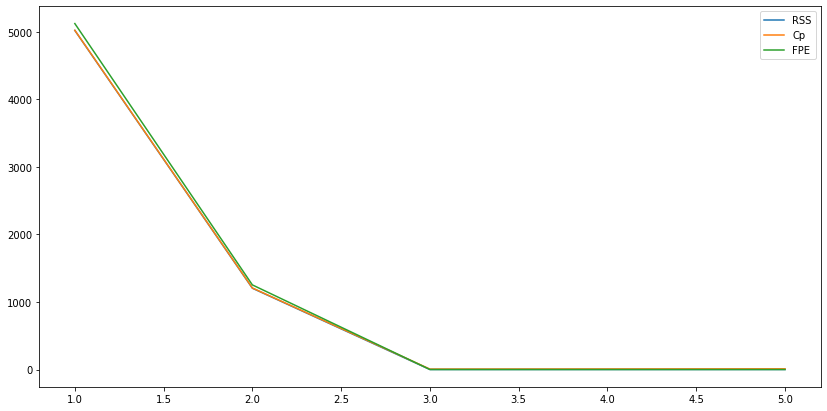

     s          RSS           Cp          FPE
0  1.0  5020.237684  5022.237684  5121.656628
1  2.0  1203.395132  1207.395132  1252.513301
2  3.0     0.009120     6.009120     0.009684
3  4.0     0.009106     8.009106     0.009865
4  5.0     0.009035    10.009035     0.009986

n = 100
σ = 1
X:[[0.92410401 8.56846741 1.66699293 9.20211972 0.30014979]
 [9.20113867 8.39385611 2.72058852 8.15445163 8.10330747]
 [9.05824523 4.66900574 5.49345581 5.82445883 0.26108959]
 [9.10709159 3.87418431 4.74699917 1.57639844 2.02570318]
 [0.26580647 5.33533294 4.04490379 5.21469506 1.36059506]
 [6.73548517 6.91283829 9.77712962 8.94491921 4.87429282]
 [2.28319084 3.55571049 0.47975262 2.14314039 7.51133604]
 [0.40547162 0.45240149 0.93444509 6.06799017 0.31675938]
 [0.1559607  4.27733055 9.19978416 2.27673495 5.85979707]
 [8.42891678 0.45502174 9.28683385 8.0301696  9.44125727]
 [1.15741245 3.14295598 4.41882004 3.73937487 1.41816842]
 [5.78417132 7.92654958 8.63964232 0.32544763 7.76736068]
 [7.7313765

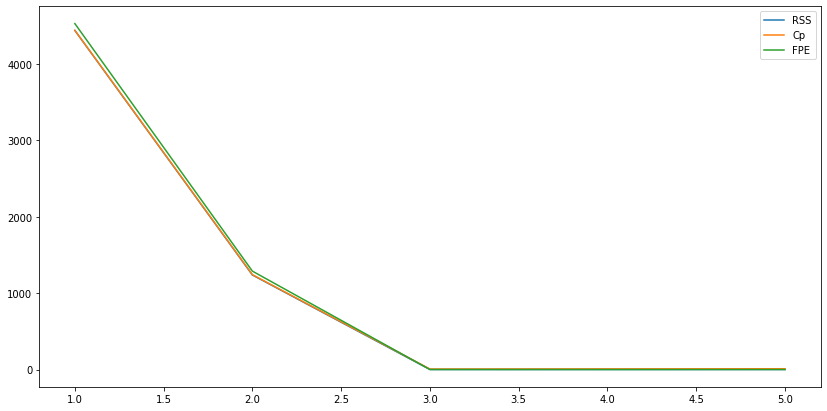

     s          RSS           Cp          FPE
0  1.0  4438.205194  4440.205194  4527.865905
1  2.0  1237.185939  1241.185939  1287.683324
2  3.0     0.009139     6.009139     0.009705
3  4.0     0.008796     8.008796     0.009529
4  5.0     0.008472    10.008472     0.009364



In [893]:
m = 5
n_list = [10, 30, 100]
theta = np.array([3, -2, 1, 0, 0])
sigma_list = [0.1, 0.5, 1]
s = 5
for n in n_list: 
    for sigma in sigma_list:
        X = np.random.uniform(0, 10, size=(n, m))
        ksi = np.random.normal(0, 0.01, size=n)
        y = X @ theta + ksi
        print('n = {}'.format(n))
        print('σ = {}'.format(sigma))
        print('X:{}'.format(X))
        print('y:{}'.format(y))
        theta_pred, _, _, df = RMNK(X, y, s=s, printt=True, cr_df=True)
        #p = np.flip(np.arange(m), axis=0)
        #theta_pred, _, _, df = RMNK(X[:,p], y, s=s, printt=True, cr_df=True)
        print('True values: θ= {}'.format(theta))
        print('Estimates: θ*= {}'.format(theta_pred[:,0]))
        plt.plot(df['s'], df['RSS'], label='RSS')
        plt.plot(df['s'], df['Cp'], label='Cp')
        plt.plot(df['s'], df['FPE'], label='FPE')
        plt.legend()
        plt.show()
        print(df)
        print()